# points

> binomial and poisson point process

In [ ]:
#| hide
#| default_exp points

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Literal, Optional
from fastcore.basics import patch
import functools

import numpy as np
from scipy.spatial import ConvexHull

In [ ]:
#|export

def in_hull(point:np.array,  # 1d array 
            hull:ConvexHull, # see scipy.spatial
            tol=1e-9): 
    """checks whether point is inside hull"""
    assert len(point)==hull.ndim, "expect point, hull in the same dimension"
    W,b = hull.equations[:,:-1], hull.equations[:,-1]
    return np.all(W@point+b<=tol)

In [ ]:
#|export
class Points:
    """define binomial or poisson point process in a convex polytope"""
    def __init__(self, n:int, # (expected) number of points 
                d=2,  # dimensionality
                seed: Optional[int]=None, 
                law: Literal["binomial","poisson"]="binomial", # distribution of the points 
                shape: Optional[ConvexHull]=None): # sample from shape, default to unit box
        assert law in ["binomial","poisson"]
        self.rng = np.random.default_rng(seed)
        self.n = self.rng.poisson(n) if law == "poisson" else n
        self.d = d
        self.shape = shape
    
    @functools.cached_property
    def points(self):
        """actually generate points from the prescribed distribution"""
        if self.shape is None: # unit cube
            return self.rng.uniform(size=(self.n,self.d))
        else:
            ps = []
            for _ in range(self.n):
                while True:
                    # must mint new point, no seed passed
                    sample = np.random.default_rng().uniform(self.shape.min_bound, self.shape.max_bound,(self.d,))                     
                    if in_hull(sample, self.shape): ps.append(sample); break
            assert len(ps)==self.n
            return np.array(ps)
        
    @functools.cached_property
    def distance_matrix(self):
        ps = self.points
        diff = ps[:,None,:] - ps[None,:,:]
        return np.linalg.norm(diff,axis=-1)

In [ ]:
import matplotlib.pyplot as plt

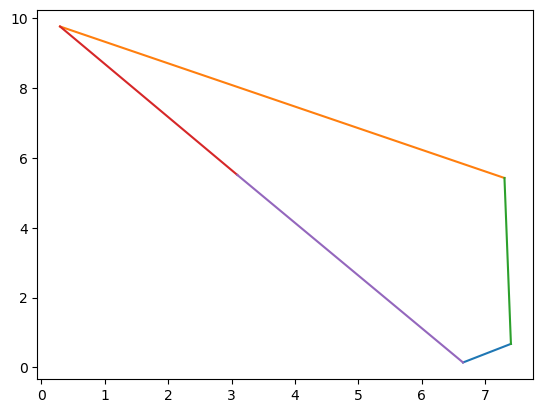

In [ ]:
rng = np.random.default_rng()
vertices = rng.uniform(0,10,size=(5,2))
hull = ConvexHull(vertices)
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

False


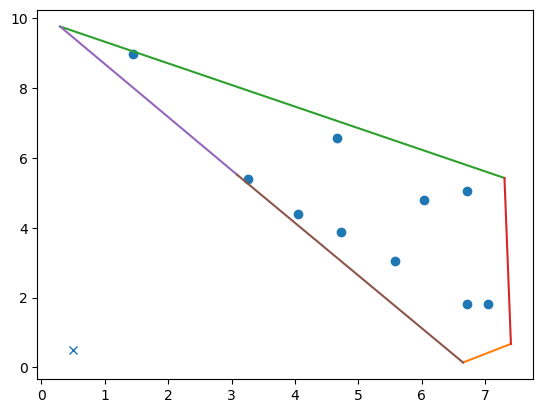

In [ ]:

process = Points(10,shape=hull)
bin = process.points
p = np.array([0.5,0.5])
print(in_hull(p, hull))
plt.scatter(*bin.T)
plt.plot(*p, 'x')
for s in hull.simplices:
    plt.plot(vertices[s,0], vertices[s,1])

In [ ]:
Points(5,d=3,shape=ConvexHull(np.random.default_rng().uniform(size=(4,3)))).points

array([[0.59676873, 0.5021933 , 0.41654714],
       [0.50174588, 0.59266022, 0.65797975],
       [0.59922938, 0.5984525 , 0.39111022],
       [0.52473367, 0.60297597, 0.52765394],
       [0.60523702, 0.3054551 , 0.1965878 ]])

In [ ]:
#|export

@patch
def lnnl(self:Points,k:int=1):
    """computes largest k-nearest neighbour link"""
    ds = self.distance_matrix
    idx = np.argpartition(ds,k,-1)[:,k] # k-th col is the index of the k-th smallest val for each row. NOTE: diagonal of ds are 0s   
    return ds[np.arange(self.n),idx].max()

In [ ]:
process.lnnl(), process.lnnl(2), process.lnnl(3) 

(4.018739424904923, 4.024645893978189, 5.278054005535041)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()